## Group Name : Inside Roll
## Group Members: 
#### 1. AIT2304037 Chin Jun Ming 
#### 2. AIT2304038 Chin Zheng Dong
#### 3. AIT2304041 Tan Wai Hong
#### 4. AIT2304043 Wong Jing
#### 5. AIT2304044 Yee Sue Jing

#### Importing and initialising

In [29]:
# Base path of dataset on your computer

base_path = "C:\\Users\\Adrian\\Downloads\\archive"

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import json
import mycvlib as cv
from PIL import Image
from skimage.transform import rescale

import cv2
import torch


In [31]:
# Initialising helper functions

def get_first_n_pairs(my_dict, n):
    new_dict = {}
    counter = 0
    for obj in my_dict:
        new_dict[obj] = my_dict[obj]
        counter += 1
        if counter >= n:
            return new_dict

def print_dict(my_dict):
     print(json.dumps(my_dict, indent=4, separators=(',', ': ')))

In [32]:
# setting seed to make sure all random results are always the same

random.seed(87)
np.random.seed(87)

#### Opening dataset

In [33]:
# open json file of dataset

training_image_path = "\\coco2017\\train2017\\"
training_label_path = "\\coco2017\\annotations\\instances_train2017.json"

with open(base_path + training_label_path, 'r') as file:
    data = json.load(file)

#### Displaying Basic Information

In [34]:
number_of_images = len(data["images"])
print("number of images: " + str(number_of_images))

number of images: 118287


In [35]:
print(f"json keys: {data.keys()}")
print(f"images keys: {data['images'][0].keys()}")
print(f"annotation keys: {data['annotations'][0].keys()}")
print(f"categories keys: {data['categories'][0].keys()}")

json keys: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])
images keys: dict_keys(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'])
annotation keys: dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])
categories keys: dict_keys(['supercategory', 'id', 'name'])


In [36]:
categories = {}
for idx,j in enumerate(data["categories"]):
    # categories[train_json_dataset["categories"][idx]['id']] = j['name']
    categories.update({data['categories'][idx]['id']:j['name']})

print(f"list of categories: {categories}")

list of categories: {1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cel

# __Preprocessing__

#### Missing Data

In [37]:
image_id_array = [image["id"] for image in data["images"]]
annotation_ids = np.unique([annotation["image_id"] for annotation in data["annotations"]], return_counts=False)

non_missing_image_ids = np.intersect1d(image_id_array, annotation_ids)
missing_image_ids = np.setdiff1d(image_id_array, annotation_ids)

print(f"number of images with annotations: {len(non_missing_image_ids)}")
print(f"number of images without annotations: {len(missing_image_ids)}")
print(f"percentage of missing data: {np.round(len(missing_image_ids) / number_of_images * 100, 2)}%")

number of images with annotations: 117266
number of images without annotations: 1021
percentage of missing data: 0.86%


In [38]:
cat_id2name = {cat["id"]:cat["name"] for cat in data["categories"]}
cat_name2id = {cat["name"]:cat["id"] for cat in data["categories"]}
image_id2file = { image['id']: image['file_name'] for image in data['images']}

In [39]:
images_label = dict()
for obj in data['annotations']:
    image_id = obj["image_id"]
    if image_id in images_label:
        images_label[image_id]["segmentation"].append(obj["segmentation"])
        images_label[image_id]["area"].append(obj["area"])
        images_label[image_id]["iscrowd"].append(obj["iscrowd"])
        images_label[image_id]["bbox"].append(obj["bbox"])
        images_label[image_id]["category_id"].append(obj["category_id"])
    else:
        label = {
            "segmentation": [obj["segmentation"]],
            "area": [obj["area"]],
            "iscrowd": [obj["iscrowd"]],
            "bbox": [obj["bbox"]],
            "category_id": [obj["category_id"]]
        }
        images_label[image_id] = label


Note: The structure of the dictionary is changed to make it more readable and easier to manage. The keys of the new dictionary are id of the images, the values are dictionary of information of the image which includes its file name and its labels.

In [40]:
data_new = {}
for id in image_id_array:
    if id not in annotation_ids:
        data_new[id] = {
            "file_name": image_id2file[id],

            "annotations": []
        }
    else:
        annotations_array = []

        for i in range(len(images_label[id]["bbox"])):
            dict_temp = {
                "bbox": images_label[id]["bbox"][i],
                "category_id": images_label[id]["category_id"][i],
                "category_name": categories[images_label[id]["category_id"][i]]
            }
            annotations_array.append(dict_temp)

        data_new[id] = {
            "file_name": image_id2file[id],

            "annotations": annotations_array
        }

Note: The dictionary printed below shows the structure of the processed data

In [41]:
dict_temp = get_first_n_pairs(data_new, 3)
print_dict(dict_temp)

{
    "391895": {
        "file_name": "000000391895.jpg",
        "annotations": [
            {
                "bbox": [
                    359.17,
                    146.17,
                    112.45,
                    213.57
                ],
                "category_id": 4,
                "category_name": "motorcycle"
            },
            {
                "bbox": [
                    339.88,
                    22.16,
                    153.88,
                    300.73
                ],
                "category_id": 1,
                "category_name": "person"
            },
            {
                "bbox": [
                    471.64,
                    172.82,
                    35.92,
                    48.1
                ],
                "category_id": 1,
                "category_name": "person"
            },
            {
                "bbox": [
                    486.01,
                    183.31,
                    30.63,
          

#### Dataset

Displaying the images and its labels

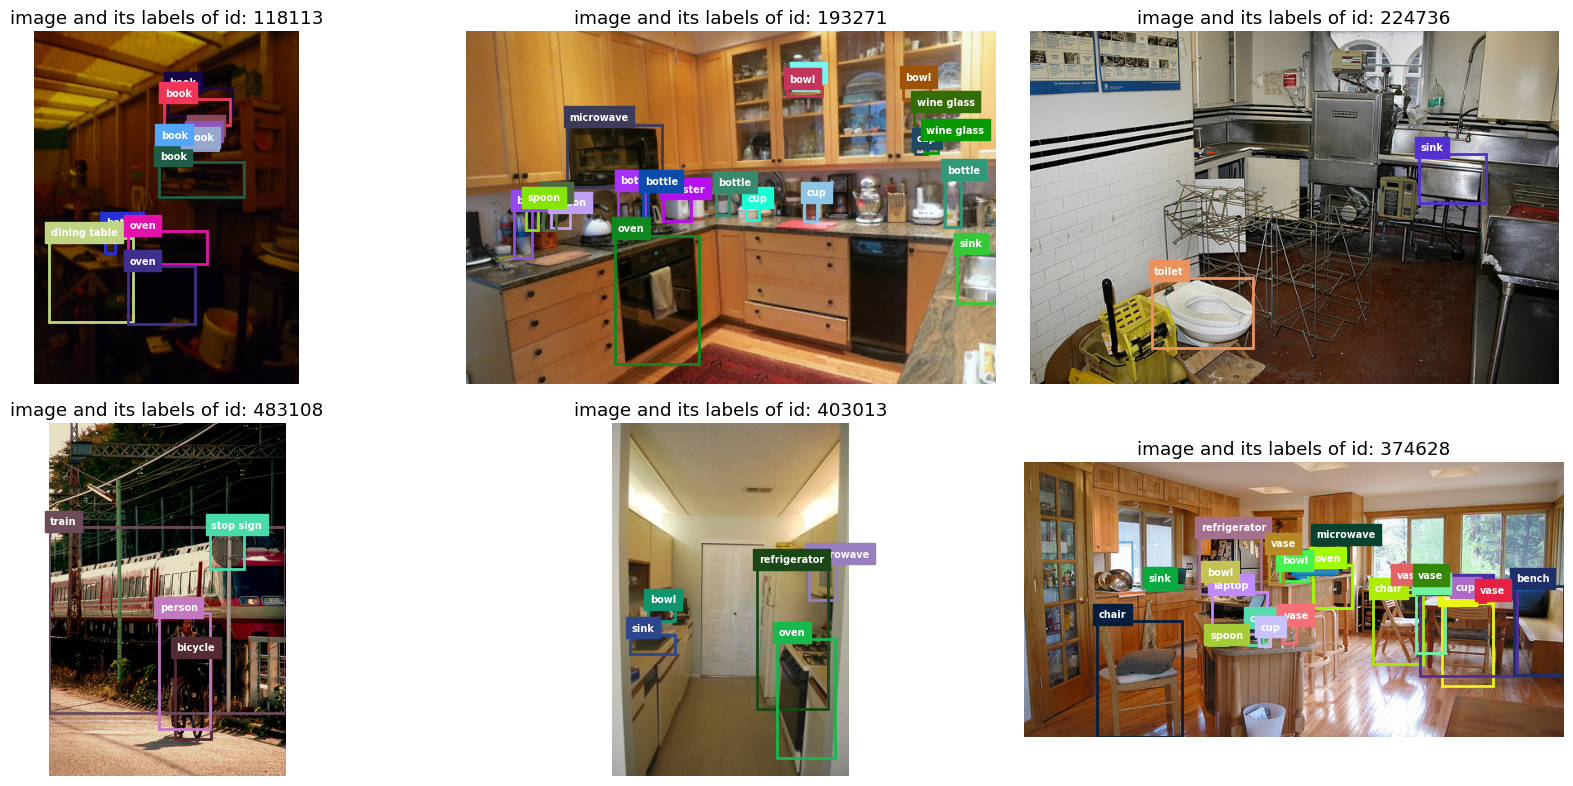

In [42]:
fig, ax = plt.subplots(2, 3, figsize=(17, 8))
keys_temp = list(data_new.keys())[10:16]

for j in range(6):
    id = keys_temp[j]
    a = j // 3
    b = j % 3

    image_3d, image_2d = cv.open_image(base_path + training_image_path + data_new[id]["file_name"])
    ax[a, b].imshow(image_3d)
    ax[a, b].axis("off")
    ax[a, b].set_title(f"image and its labels of id: {id}")

    for i in range(len(data_new[id]["annotations"])):
        color = (random.random(),random.random(),random.random())
        bbox = data_new[id]["annotations"][i]["bbox"]
        ax[a, b].add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor=(color),linewidth=2))
        ax[a, b].text(bbox[0] + 2, bbox[1] - 5, categories[data_new[id]["annotations"][i]["category_id"]], color='white', fontsize=7, weight='bold', backgroundcolor=color)

plt.tight_layout()
plt.show()

#### Frequency of each category in the dataset

frequency of each object:

person: 262465
car: 43867
chair: 38491
book: 24715
bottle: 24342
cup: 20650
dining table: 15714
bowl: 14358
traffic light: 12884
handbag: 12354
umbrella: 11431
bird: 10806
boat: 10759
truck: 9973
bench: 9838
sheep: 9509
banana: 9458
kite: 9076
motorcycle: 8725
backpack: 8720
potted plant: 8652
cow: 8147
wine glass: 7913
carrot: 7852
knife: 7770
broccoli: 7308
donut: 7179
bicycle: 7113
skis: 6646
vase: 6613
horse: 6587
tie: 6496
cell phone: 6434
orange: 6399
cake: 6353
sports ball: 6347
clock: 6334
suitcase: 6192
spoon: 6165
surfboard: 6126
bus: 6069
apple: 5851
pizza: 5821
tv: 5805
couch: 5779
remote: 5703
sink: 5610
skateboard: 5543
elephant: 5513
dog: 5508
fork: 5479
zebra: 5303
airplane: 5135
giraffe: 5131
laptop: 4970
tennis racket: 4812
teddy bear: 4793
cat: 4768
train: 4571
sandwich: 4373
bed: 4192
toilet: 4157
baseball glove: 3747
oven: 3334
baseball bat: 3276
hot dog: 2918
keyboard: 2855
snowboard: 2685
frisbee: 2682
refrigerator: 2637
mouse: 2262
sto

Text(0.5, 1.0, 'top 10 least common objects')

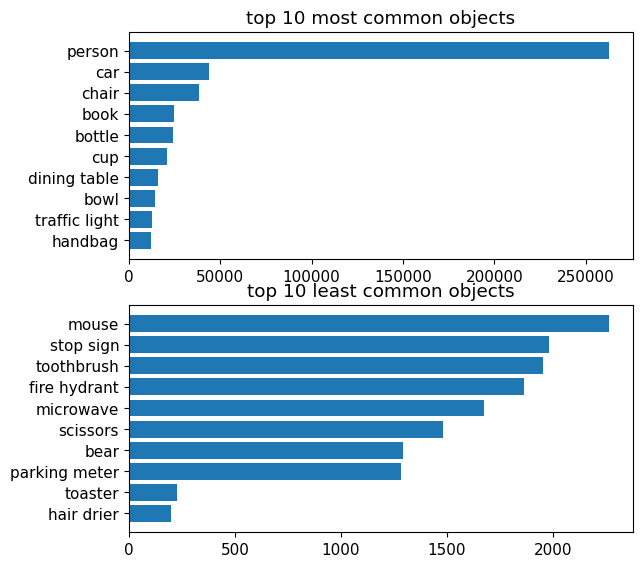

In [43]:
category_id_array = []
for id in image_id_array:
    for j in range(len(data_new[id]["annotations"])):
        category_id_array.append(data_new[id]["annotations"][j]["category_name"])

category_name_array, frequency_array = np.unique(category_id_array, return_counts=True)

sorted_indeces = np.argsort(frequency_array)
sorted_category_name_array = category_name_array[sorted_indeces]
sorted_frequency_array = frequency_array[sorted_indeces]

print("frequency of each object:\n")
for i in range(len(sorted_category_name_array) - 1, -1, -1):
    print(f"{sorted_category_name_array[i]}: {sorted_frequency_array[i]}")

plt.figure(figsize=(6.5, 6.5))

plt.subplot(2, 1, 1)
plt.barh(np.arange(len(sorted_frequency_array))[-10:], sorted_frequency_array[-10:])
plt.yticks(np.arange(len(sorted_frequency_array))[-10:], labels=sorted_category_name_array[-10:])
plt.title("top 10 most common objects")

plt.subplot(2, 1, 2)
plt.barh(np.arange(len(sorted_frequency_array))[:10], sorted_frequency_array[:10])
plt.yticks(np.arange(len(sorted_frequency_array))[:10], labels=sorted_category_name_array[:10])
plt.title("top 10 least common objects")


#### Image dimension

The code below collects the dimensions of every image and saves it as image_dimensions.npy. It is commented because it is very slow

In [44]:
# width_array = np.zeros(len(image_id_array))
# height_array = np.zeros(len(image_id_array))

# for i in range(len(image_id_array)):
#     print(i / number_of_images)
#     id = image_id_array[i]
#     image_3d = cv2.imread(base_path + training_image_path + data_new[id]["file_name"])
    
#     width = image_3d.shape[1]
#     height = image_3d.shape[0]

#     width_array[i] = width
#     height_array[i] = height

# image_dimensions_array = np.concatenate((np.array([width_array]), np.array([height_array])))
# np.save("image_dimensions.npy", image_dimensions_array)

Text(0.5, 1.0, 'scatterplot of image dimensions')

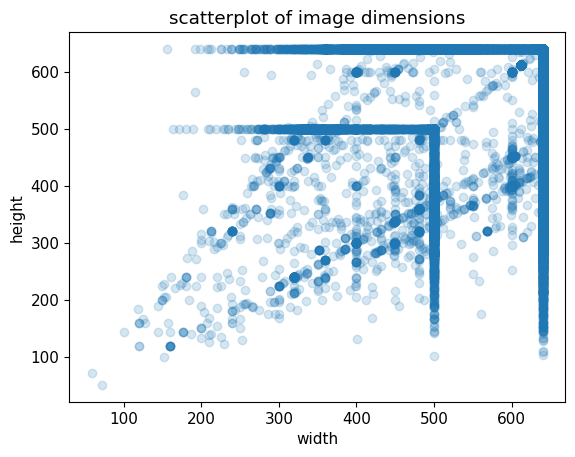

In [45]:
image_dimensions_array = np.load("image_dimensions.npy")
width_array = image_dimensions_array[0]
height_array = image_dimensions_array[1]

plt.scatter(width_array, height_array, alpha=0.18)
plt.xlabel("width")
plt.ylabel("height")
plt.title("scatterplot of image dimensions")

#### Outliers

largest width: 640.0
largest height: 640.0
smallest width: 59.0
smallest height: 51.0
largest aspect ratio: 6.153846153846154
smallest aspect ratio: 0.24375


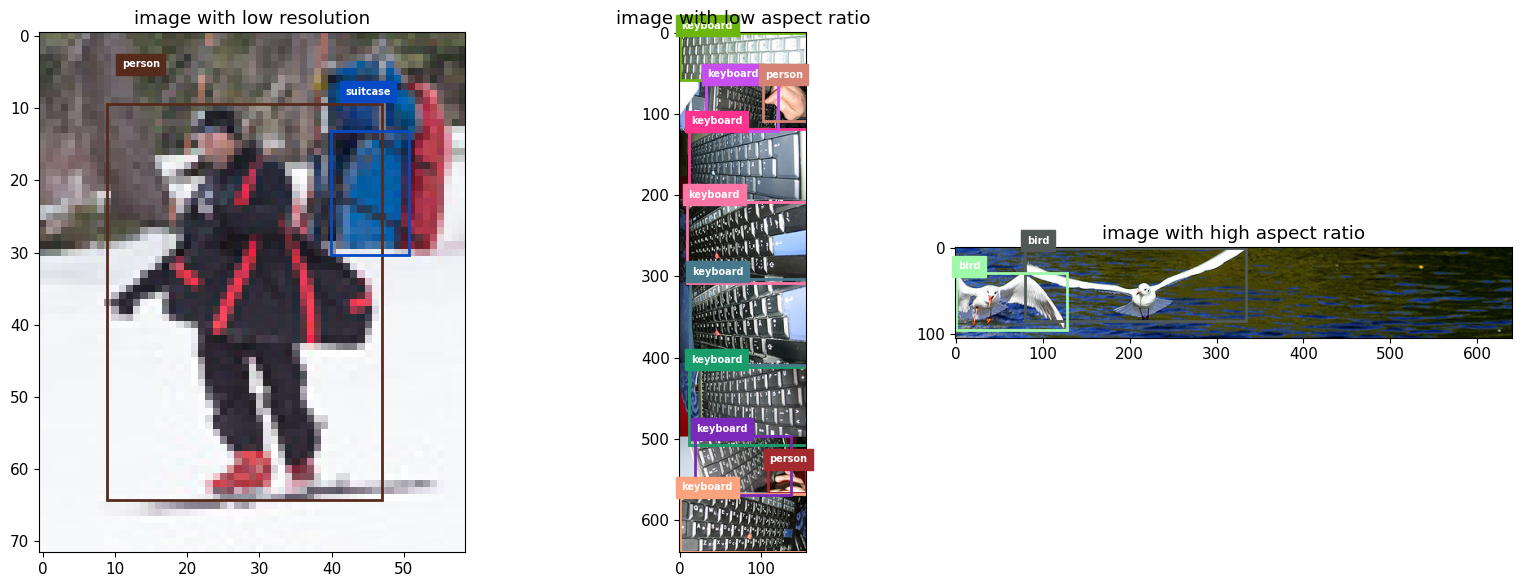

In [46]:
aspect_ratio_array = np.zeros(number_of_images)
for i in range(number_of_images):
    aspect_ratio_array[i] = width_array[i] / height_array[i]

temp_id_array = [image_id_array[np.argmin(width_array)], image_id_array[np.argmin(aspect_ratio_array)], image_id_array[np.argmax(aspect_ratio_array)]]
temp_labels = ["image with low resolution", "image with low aspect ratio", "image with high aspect ratio"]

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
for j in range(3):
    id = temp_id_array[j]

    image_3d, image_2d = cv.open_image(base_path + training_image_path + data_new[id]["file_name"])
    ax[j].imshow(image_3d)
    ax[j].set_title(temp_labels[j])

    for i in range(len(data_new[id]["annotations"])):
        color = (random.random(),random.random(),random.random())
        bbox = data_new[id]["annotations"][i]["bbox"]
        ax[j].add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor=(color),linewidth=2))
        ax[j].text(bbox[0] + 2, bbox[1] - 5, categories[data_new[id]["annotations"][i]["category_id"]], color='white', fontsize=7, weight='bold', backgroundcolor=color)

print(f"largest width: {np.max(width_array)}")
print(f"largest height: {np.max(height_array)}")
print(f"smallest width: {np.min(width_array)}")
print(f"smallest height: {np.min(height_array)}")
print(f"largest aspect ratio: {np.max(aspect_ratio_array)}")
print(f"smallest aspect ratio: {np.min(aspect_ratio_array)}")

plt.tight_layout()
plt.show()


# __Pre-trained Model__

The pre-trained Yolo we choose is YOLOv5s, and the training dataset used by yolov5s just happens to be the coco dataset, so we don't need to do transfer learning. We will also mention the relevant introduction in the report.

In [47]:
model = torch.hub.load("ultralytics/yolov5","yolov5s")

requirements: Ultralytics requirements ['gitpython>=3.1.30', 'pillow>=10.3.0', 'requests>=2.32.2', 'tqdm>=4.66.3', 'setuptools>=70.0.0'] not found, attempting AutoUpdate...


Using cache found in C:\Users\Adrian/.cache\torch\hub\ultralytics_yolov5_master


Retry 1/2 failed: Command 'pip install --no-cache-dir "gitpython>=3.1.30" "pillow>=10.3.0" "requests>=2.32.2" "tqdm>=4.66.3" "setuptools>=70.0.0" ' returned non-zero exit status 1.
Retry 2/2 failed: Command 'pip install --no-cache-dir "gitpython>=3.1.30" "pillow>=10.3.0" "requests>=2.32.2" "tqdm>=4.66.3" "setuptools>=70.0.0" ' returned non-zero exit status 1.
requirements:  Command 'pip install --no-cache-dir "gitpython>=3.1.30" "pillow>=10.3.0" "requests>=2.32.2" "tqdm>=4.66.3" "setuptools>=70.0.0" ' returned non-zero exit status 1.


YOLOv5  2024-11-26 Python-3.11.4 torch-2.5.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [48]:
model.eval()

AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

# Visual Result of Pre-trained Model in coco dataset

## helper function for visualize

In [49]:
def color_seed(rand_seed):
    random.seed(rand_seed)
    return {i:(random.random(),random.random(),random.random())  for i in categories.values()}


This function will show 3 image result: original image, original image are annotated based on human, original image are annotated based on model

In [50]:
def visualize_image_result(img_id):
    
    img = plt.imread(base_path + training_image_path + data_new[img_id]["file_name"])
    color = color_seed(40)
    
    fig,axes = plt.subplots(1,3,figsize=(20,6))
    
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(img)
    axes[1].set_title("Annotation Image")
    axes[1].axis('off')
    
    for annotations in data_new[img_id]["annotations"]:
        x1, y1, x1_length, y1_length = annotations['bbox']
        label1 = annotations["category_name"]
        axes[1].add_patch(plt.Rectangle((x1, y1), x1_length, y1_length, fill=False, edgecolor=color[label1], linewidth=2))
        axes[1].text(x1, y1 - 10, f"{label1}", color='white', fontsize=11, weight='bold', backgroundcolor=color[label1])
        
    axes[2].imshow(img)
    axes[2].set_title("Result")
    axes[2].axis('off')
    
    
    result = model(img)
    df = result.pandas().xyxy[0]
    obj_num = df.shape[0]
    
    for j in range(obj_num):
         
        x = df.iloc[j]['xmin']
        y = df.iloc[j]['ymin']
        x_length = df.iloc[j]['xmax'] - df.iloc[j]['xmin']
        y_length = df.iloc[j]['ymax'] - df.iloc[j]['ymin']
        
        label = df.iloc[j]['name']
        confidence = df.iloc[j]['confidence']
        id2 = df.iloc[j]['class']
        axes[2].add_patch(plt.Rectangle((x, y), x_length, y_length, fill=False, edgecolor=color[label], linewidth=2))
        axes[2].text(x, y - 10, f"{label} {round(confidence, 2)}", color='white', fontsize=11, backgroundcolor=color[label])
    
    plt.tight_layout()
    plt.show()

## visualize part

C:\Users\Adrian/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


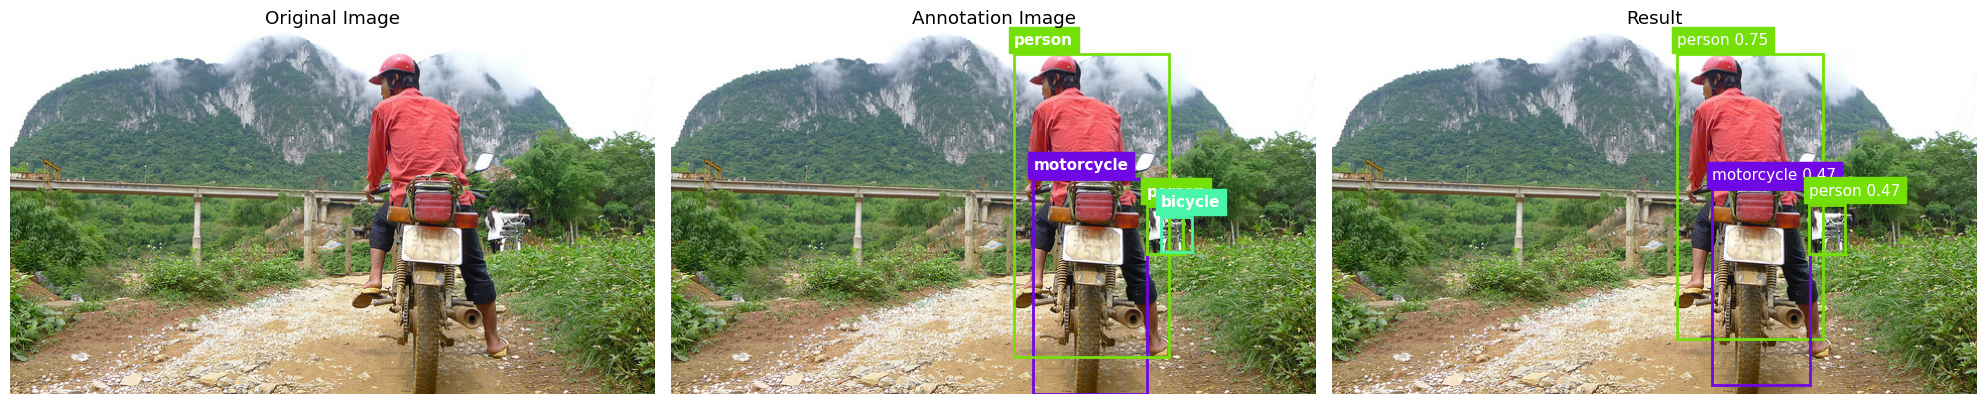

In [51]:
%matplotlib inline
visualize_image_result(image_id_array[0])

For model evaluation, we use the function provided by yolov5, which is called by the terminal, so we only write the results of this part in the report.
Although we also have our own evaluation function, due to the low efficiency of our function and the huge size of coco-dataset, we only use our own evaluation function when evaluating our own dataset of 100 photos.
command we used: python val.py --data data/coco.yaml --weights yolov5s.pt

# Visual Result and evaluation of Pre-trained Model in our 100 image dataset


## helper functions that help us evaluate our model
#### to calculate:
- iou
- precision
- recall
- F1 score
- Average precision (AP)
- mean Average precision (mAP)

In [52]:
def calculate_iou(box1, box2):
    new_box1 = [box1[0], box1[1], box1[0] + box1[2], box1[1] + box1[3]]
    new_box2 = [box2[0], box2[1], box2[0] + box2[2], box2[1] + box2[3]]
    
    x1 = max(new_box1[0], new_box2[0])
    y1 = max(new_box1[1], new_box2[1])
    x2 = min(new_box1[2], new_box2[2])
    y2 = min(new_box1[3], new_box2[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = (new_box1[2] - new_box1[0]) * (new_box1[3] - new_box1[1])
    box2_area = (new_box2[2] - new_box2[0]) * (new_box2[3] - new_box2[1])

    union_area = box1_area + box2_area - intersection_area

    if union_area == 0:
        return 0  
    iou = intersection_area / union_area
    return iou
    

In [53]:
def precision_recall(labels, predictions, iou_threshold=0.5):
    matched_labels = set()
    true_positives = 0
    
    for pred in predictions:
        for i, label in enumerate(labels):
            iou = calculate_iou(pred, label)
            if iou >= iou_threshold and i not in matched_labels:
                true_positives += 1
                matched_labels.add(i)
                break

    false_positives = len(predictions) - true_positives
    false_negatives = len(labels) - len(matched_labels)
    
    precision = true_positives / (true_positives + false_positives) if predictions else 0
    recall = true_positives / (true_positives + false_negatives) if labels else 0
    
    return precision, recall
    

In [54]:
def true_positives(labels, predictions, iou_threshold=0.5):
    matched_labels = set()
    true_positives = 0
    
    for pred in predictions:
        for i, label in enumerate(labels):
            iou = calculate_iou(pred, label)
            if iou >= iou_threshold and i not in matched_labels:
                true_positives += 1
                matched_labels.add(i)
                break

    
    return true_positives
    

In [55]:
def calculate_f1(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if precision + recall else 0

In [56]:
def calculate_average_precision(precisions, recalls):
    recalls = np.concatenate([[0], recalls, [1]])
    precisions = np.concatenate([[0], precisions, [0]])

    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = max(precisions[i], precisions[i + 1])

    indices = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])
    return ap

## Import the image dataset collect by us.

In [57]:
with open('our_image_data.json', 'r') as infile:
    
    data = json.load(infile)

FileNotFoundError: [Errno 2] No such file or directory: 'our_image_data.json'

## Visualize the prediction of model on our image dataset

In [ ]:

visualize_image_name = "001.jpg"
img = plt.imread("our_image/" + visualize_image_name)
color = color_seed(40)

fig,axes = plt.subplots(1,3,figsize=(20,6))

axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(img)
axes[1].set_title("Annotation Image")
axes[1].axis('off')

for bbox, cat_id in zip(data[visualize_image_name]['bboxs'], data[visualize_image_name]['categories']):
    x1, y1, x1_length, y1_length = bbox
    label1 = cat_id2name[cat_id]
    axes[1].add_patch(plt.Rectangle((x1, y1), x1_length, y1_length, fill=False, edgecolor=color[label1], linewidth=2))
    axes[1].text(x1, y1 - 10, f"{label1}", color='white', fontsize=11, weight='bold', backgroundcolor=color[label1])
    
axes[2].imshow(img)
axes[2].set_title("Result")
axes[2].axis('off')


result = model(img)
df = result.pandas().xyxy[0]
obj_num = df.shape[0]

for j in range(obj_num):
     
    x = df.iloc[j]['xmin']
    y = df.iloc[j]['ymin']
    x_length = df.iloc[j]['xmax'] - df.iloc[j]['xmin']
    y_length = df.iloc[j]['ymax'] - df.iloc[j]['ymin']
    
    label = df.iloc[j]['name']
    confidence = df.iloc[j]['confidence']
    id2 = df.iloc[j]['class']
    axes[2].add_patch(plt.Rectangle((x, y), x_length, y_length, fill=False, edgecolor=color[label], linewidth=2))
    axes[2].text(x, y - 10, f"{label} {round(confidence, 2)}", color='white', fontsize=11, backgroundcolor=color[label])

plt.tight_layout()
plt.show()

## Evaluate the model on our 100 image dataset

In [ ]:
confident = 0.5

for i in range(100):
    if f"{i}" in cat_id2name.keys():
        print(f'{i}: {cat_id2name[f"{i}"]}')
        category = cat_id2name[f"{i}"]
        labels_count = 0
        true_positive_count = 0
        all_positive_count = 0
        
        for image_name in data:
            label_array_in_one_image = []
            predictions_array_in_one_image = []
            for bbox, cat_id2name in zip(data[image_name]['bboxs'], data[image_name]['categories']):
                if cat_id2name[f"{cat_id2name}"] == category:
                    labels_count += 1
                    label_array_in_one_image.append(bbox)
                    
            results = model('our_image/' + image_name)
            
            df = results.pandas().xyxy[0]
            specific_detect = df[df["name"] == category]
            specific_detect = specific_detect[specific_detect["confidence"] > confident]
            all_positive_count += len(specific_detect)
            
            for index, row in specific_detect.iterrows():
                bbox = [int(row['xmin']), int(row['ymin']), int(row['xmax'] - row['xmin']), int(row['ymax'] - row['ymin'])]
                predictions_array_in_one_image.append(bbox)
                
            true_positive_count += true_positives(label_array_in_one_image, predictions_array_in_one_image)
        
        print(f"{labels_count=}")
        print(f"{true_positive_count=}")
        print(f"{all_positive_count=}")
        if all_positive_count > 0:
            print(f"precision={true_positive_count/all_positive_count}")
        if labels_count > 0:
            print(f"recall={true_positive_count/labels_count}")
        print()

# __Experiment__

Experiments are done on the validation data, therefore validation images and labels are needed

In [ ]:
validation_image_path = "\\coco2017\\val2017\\"
validation_label_path = "\\coco2017\\annotations\\instances_val2017.json"

with open(base_path + validation_label_path, 'r') as file:
    val_data = json.load(file)

In [ ]:
number_of_images_val = len(val_data)
print("number of validation images: " + number_of_images_val)

Same as the data above, the validation data is preprocessed

In [ ]:
val_image_id_array = [image["id"] for image in val_data["images"]]
annotation_ids = np.unique([annotation["image_id"] for annotation in val_data["annotations"]], return_counts=False)

cat_id2name = {cat["id"]:cat["name"] for cat in val_data["categories"]}
cat_name2id = {cat["name"]:cat["id"] for cat in val_data["categories"]}
image_id2file = { image['id']: image['file_name'] for image in val_data['images']}

images_label = dict()
for obj in val_data['annotations']:
    image_id = obj["image_id"]
    if image_id in images_label:
        images_label[image_id]["segmentation"].append(obj["segmentation"])
        images_label[image_id]["area"].append(obj["area"])
        images_label[image_id]["iscrowd"].append(obj["iscrowd"])
        images_label[image_id]["bbox"].append(obj["bbox"])
        images_label[image_id]["category_id"].append(obj["category_id"])
    else:
        label = {
            "segmentation": [obj["segmentation"]],
            "area": [obj["area"]],
            "iscrowd": [obj["iscrowd"]],
            "bbox": [obj["bbox"]],
            "category_id": [obj["category_id"]]
        }
        images_label[image_id] = label

val_data_new = {}
for id in val_image_id_array:
    if id not in annotation_ids:
        val_data_new[id] = {
            "file_name": image_id2file[id],

            "annotations": []
        }
    else:
        annotations_array = []

        for i in range(len(images_label[id]["bbox"])):
            dict_temp = {
                "bbox": images_label[id]["bbox"][i],
                "category_id": images_label[id]["category_id"][i],
                "category_name": categories[images_label[id]["category_id"][i]]
            }
            annotations_array.append(dict_temp)

        val_data_new[id] = {
            "file_name": image_id2file[id],

            "annotations": annotations_array
        }

In [ ]:
a = get_first_n_pairs(val_data_new, 5)
print_dict(a)

{
    "397133": {
        "file_name": "000000397133.jpg",
        "annotations": [
            {
                "bbox": [
                    217.62,
                    240.54,
                    38.99,
                    57.75
                ],
                "category_id": 44,
                "category_name": "bottle"
            },
            {
                "bbox": [
                    1.0,
                    240.24,
                    346.63,
                    186.76
                ],
                "category_id": 67,
                "category_name": "dining table"
            },
            {
                "bbox": [
                    388.66,
                    69.92,
                    109.41,
                    277.62
                ],
                "category_id": 1,
                "category_name": "person"
            },
            {
                "bbox": [
                    135.57,
                    249.43,
                    22.32,
        

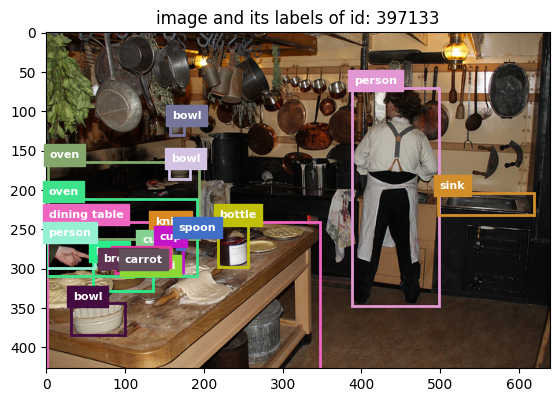

In [ ]:
def show_image_and_labels_val(image_id):
    image_3d, image_2d = cv.open_image(base_path + validation_image_path + val_data_new[image_id]["file_name"])
    fig, ax = plt.subplots(figsize=(6.5, 6.5))

    plt.imshow(image_3d)

    for i in range(len(val_data_new[image_id]["annotations"])):
        color = (random.random(),random.random(),random.random())
        bbox = val_data_new[image_id]["annotations"][i]["bbox"]
        ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor=(color),linewidth=2))
        ax.text(bbox[0] + 2, bbox[1] - 5, val_data_new[image_id]["annotations"][i]["category_name"], color='white', fontsize=8, weight='bold', backgroundcolor=color)

    plt.title(f"image and its labels of id: {image_id} (validation)")

    plt.show()

show_image_and_labels_val(397133)

# __Image Processing__

For this experiment, we process the images by brightening, darkening, blurring and adding noise to the images and let the model predict it. We then collect its result and compare it to the original images.

In [ ]:
def brighten(image_2d, factor):
    new_image_2d = np.zeros(image_2d.shape, dtype=int)
    for i in range(image_2d.shape[0]):
        for j in range(image_2d.shape[1]):
            new_image_2d[i, j] = min(factor * image_2d[i, j], 255)

    new_image_2d[0, 0] = 0
    new_image_2d[0, 1] = 255

    return new_image_2d


def darken(image_2d, factor):
    new_image_2d = np.zeros(image_2d.shape, dtype=int)
    for i in range(image_2d.shape[0]):
        for j in range(image_2d.shape[1]):
            new_image_2d[i, j] = int(image_2d[i, j] / factor)

    new_image_2d[0, 0] = 0
    new_image_2d[0, 1] = 255

    return new_image_2d

def blur(image_2d, radius):
    kernel = np.ones((2 * radius + 1, 2 * radius + 1))
    new_image_2d = cv.convolve(image_2d, kernel)

    new_image_2d[0, 0] = 0
    new_image_2d[0, 1] = 255

    return new_image_2d

def salt_and_pepper_noise(image_2d, intensity):
    new_image_2d = np.copy(image_2d)
    
    for i in range(int(2 ** intensity)):
        rand0 = int(random.random() * image_2d.shape[0])
        rand1 = int(random.random() * image_2d.shape[1])

        if (random.random() < 0.5):
            new_image_2d[rand0, rand1] = 0
        else:
            new_image_2d[rand0, rand1] = 255

    new_image_2d[0, 0] = 0
    new_image_2d[0, 1] = 255

    return new_image_2d    

In [ ]:
# helper functions

def open_image_val(id):
    image_3d, image_2d = cv.open_image(base_path + validation_image_path + val_data_new[id]["file_name"])
    return image_3d, image_2d

def helper_function_1(j):
    if j == 0:
        return image_2d, "original image"
    elif j == 1:
        return brighten(image_2d, 2.5), "brighten image"
    elif j == 2:
        return darken(image_2d, 2.5), "darken image"
    elif j == 3:
        return blur(image_2d, 3), "blurred image"
    elif j == 4:
        return salt_and_pepper_noise(image_2d, 15), "noisy image"
    elif j == 5:
        a = np.ones(image_2d.shape)
        a[0, 0] = 0
        return a, ""

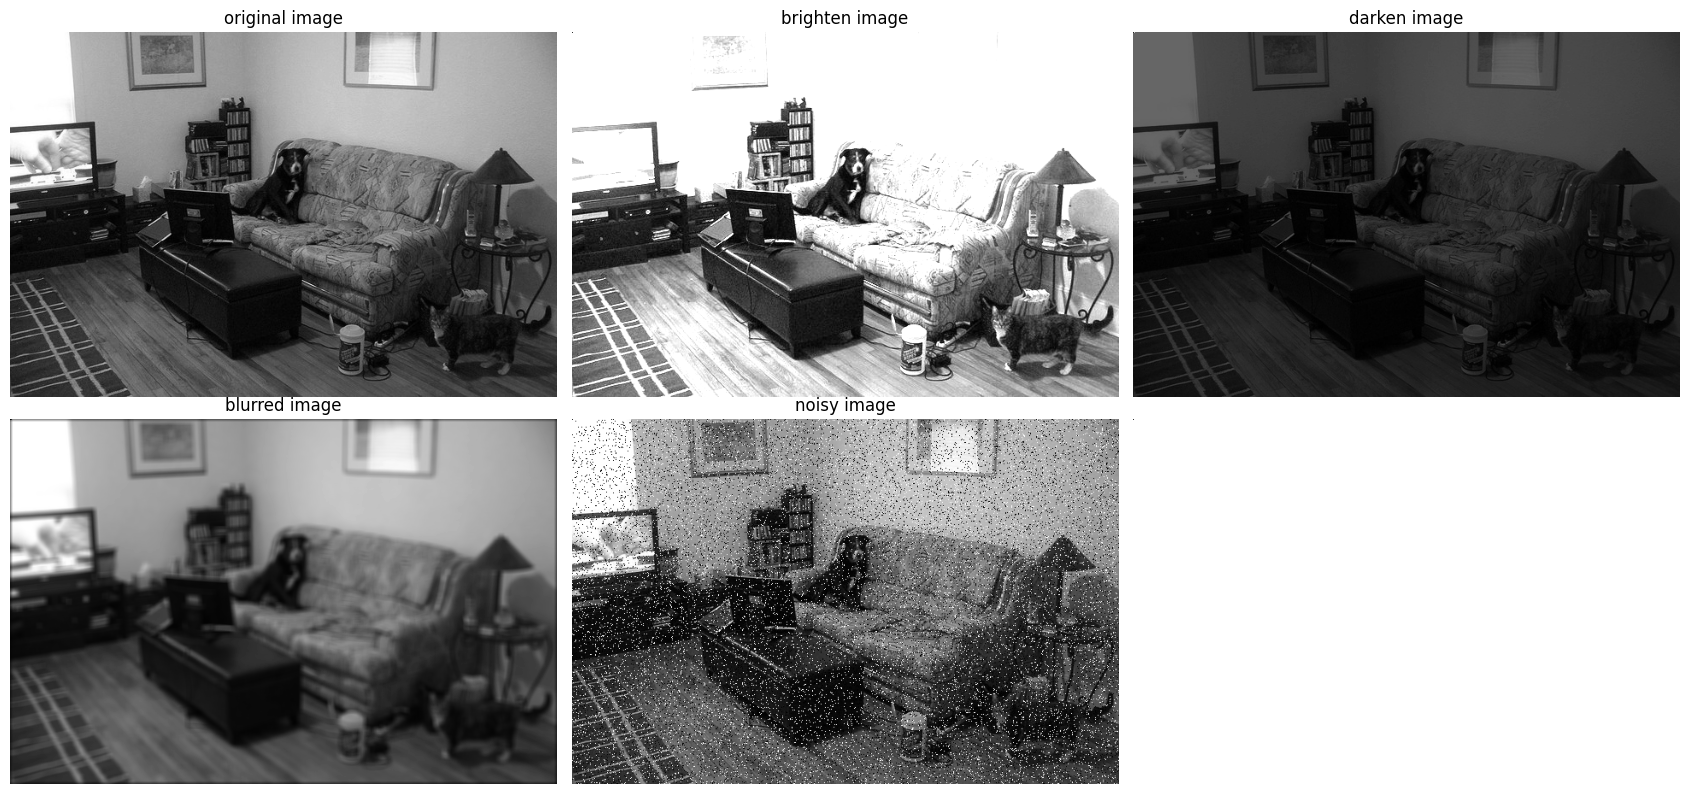

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(17, 8))

for j in range(6):
    image, title = helper_function_1(j)

    a = j // 3
    b = j % 3

    ax[a, b].imshow(image, cmap="gray")
    ax[a, b].axis("off")
    ax[a, b].set_title(title)

plt.tight_layout()
plt.show()

Instead of running the experiment on the entire validation dataset, we take a subset of the dataset and use that instead, so that the code can run faster

In [ ]:
# picking random samples from the validation dataset

sample_size = 500

sample_id_array = np.random.choice(val_image_id_array, sample_size)
print(len(val_image_id_array))
print(len(sample_id_array))

5000
500


# Hyperparameter tuning

For the model tunning part, we use the function provided by yolov5
: python train.py --data data/coco.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt --epochs 10 --batch-size 4

: python train.py --data data/coco.yaml --weights runs/train/exp9/weights/best.pt --hyp data/hyps/hyp.scratch-low.yaml --evolve --batch-size 4 --epochs 10

## Visual Result of tuned Model in coco dataset

In [ ]:
model = torch.load('best_model.pt')
model.eval()
visualize_image_result(images_label,123131)

## Visual Result and evaluation of Pre-trained Model in our 100 image dataset

### visual Result

In [ ]:

visualize_image_name = "001.jpg"
img = plt.imread("our_image/" + visualize_image_name)
color = color_seed(40)

fig,axes = plt.subplots(1,3,figsize=(20,6))

axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(img)
axes[1].set_title("Annotation Image")
axes[1].axis('off')

for bbox, cat_id in zip(data[visualize_image_name]['bboxs'], data[visualize_image_name]['categories']):
    x1, y1, x1_length, y1_length = bbox
    label1 = cat_id2name[cat_id]
    axes[1].add_patch(plt.Rectangle((x1, y1), x1_length, y1_length, fill=False, edgecolor=color[label1], linewidth=2))
    axes[1].text(x1, y1 - 10, f"{label1}", color='white', fontsize=11, weight='bold', backgroundcolor=color[label1])
    
axes[2].imshow(img)
axes[2].set_title("Result")
axes[2].axis('off')


result = model(img)
df = result.pandas().xyxy[0]
obj_num = df.shape[0]

for j in range(obj_num):
     
    x = df.iloc[j]['xmin']
    y = df.iloc[j]['ymin']
    x_length = df.iloc[j]['xmax'] - df.iloc[j]['xmin']
    y_length = df.iloc[j]['ymax'] - df.iloc[j]['ymin']
    
    label = df.iloc[j]['name']
    confidence = df.iloc[j]['confidence']
    id2 = df.iloc[j]['class']
    axes[2].add_patch(plt.Rectangle((x, y), x_length, y_length, fill=False, edgecolor=color[label], linewidth=2))
    axes[2].text(x, y - 10, f"{label} {round(confidence, 2)}", color='white', fontsize=11, backgroundcolor=color[label])

plt.tight_layout()
plt.show()

### Evaluation

In [ ]:
confident = 0.5

for i in range(100):
    if f"{i}" in cat_id2name.keys():
        print(f'{i}: {cat_id2name[f"{i}"]}')
        category = cat_id2name[f"{i}"]
        labels_count = 0
        true_positive_count = 0
        all_positive_count = 0
        
        for image_name in data:
            label_array_in_one_image = []
            predictions_array_in_one_image = []
            for bbox, cat_id2name in zip(data[image_name]['bboxs'], data[image_name]['categories']):
                if cat_id2name[f"{cat_id2name}"] == category:
                    labels_count += 1
                    label_array_in_one_image.append(bbox)
                    
            results = model('our_image/' + image_name)
            
            df = results.pandas().xyxy[0]
            specific_detect = df[df["name"] == category]
            specific_detect = specific_detect[specific_detect["confidence"] > confident]
            all_positive_count += len(specific_detect)
            
            for index, row in specific_detect.iterrows():
                bbox = [int(row['xmin']), int(row['ymin']), int(row['xmax'] - row['xmin']), int(row['ymax'] - row['ymin'])]
                predictions_array_in_one_image.append(bbox)
                
            true_positive_count += true_positives(label_array_in_one_image, predictions_array_in_one_image)
        
        print(f"{labels_count=}")
        print(f"{true_positive_count=}")
        print(f"{all_positive_count=}")
        if all_positive_count > 0:
            print(f"precision={true_positive_count/all_positive_count}")
        if labels_count > 0:
            print(f"recall={true_positive_count/labels_count}")
        print()